In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pickle
from IPython.display import clear_output as co
import warnings; # ...

import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.utils

In [2]:
le = sklearn.preprocessing.LabelEncoder
regressors = dict(sklearn.utils.all_estimators('regressor'))
metrics = sklearn.metrics._regression
mae = metrics.mean_absolute_error
mse = metrics.mean_squared_error
mape = metrics.mean_absolute_percentage_error
r2 = metrics.r2_score
me = metrics.max_error
medae = metrics.median_absolute_error
evs = metrics.explained_variance_score
mpd = metrics.mean_poisson_deviance
mgd = metrics.mean_gamma_deviance

def wape(ye, yhat):
    return np.abs(ye-yhat).sum()/ye.sum()
def e(ye, yhat):
    return np.abs(yhat-ye).sum()
def estd(ye, yhat):
    return np.abs(yhat-ye).std()

C:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


### Declarando Funções

In [154]:
def load_series(path='series/'):
    filenames = os.listdir(path)
    series, cnt, n_files = {}, 0, len(filenames)
    freq = range(1, n_files, 10)
    for filename in filenames:
        cnt+=1
        if cnt in freq: print(f'Files loaded: {cnt}/{n_files}'); co(wait=True)
        series[filename[:-4]] = pd.read_csv(path+filename, index_col=0)
    print(f'Done! Loaded {n_files} files.')
    return series

## Return random serie's city and product-type
def sample_serie():
    keys = np.random.choice(list(series.keys())).split('-')
    return keys[0], keys[1:]
    
def clean_series(series, train_min=1, drop_start_zeros=True):
    clean_series = {}
    test_empty = []
    excluded_test_index = []
    n_total = len(series)
    n_values_total = 0
    n_values_test = 0
    n_values_train = 0
    n_series = 0
    n_series_empty = 0
    n_series_test_empty = 0
    n_series_train_min_empty = 0
    n_values = 0
    n_test_empty_total = 0
    n_train_empty_total = 0
    n_non_empty_values = 0
    n_train_zeros = 0

    cnt, freq = 0, range(1, n_total, 10)
    for key in list(series.keys()):
        cnt+=1
        if cnt in freq: print(f'Cleaned series: {cnt}/{n_total}'); co(wait=True)

        msk = series[key]['year'].isin(['01/01/2016', '01/01/2017'])
        test = series[key][msk]
        train = series[key][msk==False]

        n = len(series[key])
        n_empty = series[key][target].isna().sum()
        n_test_empty = test[target].isna().sum()
        n_train_empty = train[target].isna().sum()

        cond1 = n_test_empty == len(test)
        cond2 = n_train_empty > (len(train) - train_min) # if number of training samples is greater than specified minimum.

        n_values_total += n
        n_values_test += len(test)
        n_values_train += len(train)

        n_series_empty += n==n_empty
        n_test_empty_total+=n_test_empty
        n_train_empty_total+=n_train_empty
        n_series_test_empty += cond1
        n_series_train_min_empty += cond2

        if cond1 or cond2:
            n_series+=1
            n_values+=len(series[key])
            n_non_empty_values+=(len(series[key]) - n_empty)
            excluded_test_index.extend(test[test[target].isna()==False].index.tolist())

        else:
            n_values+=n_empty
            clean_series[key] = series[key].dropna(subset=['area'])
            if drop_start_zeros:
                test_msk = clean_series[key]['year'].isin(['01/01/2016', '01/01/2017'])
                train_msk = test_msk==False
                isNotZero = (clean_series[key][train_msk]['area']!=0).tolist()
                if sum(isNotZero)!=0:
                    testset = clean_series[key][test_msk]
                    trainset_cut = clean_series[key][train_msk].iloc[isNotZero.index(True):]
                    clean_series[key] = pd.concat([trainset_cut, testset])
                    n_train_zeros+=(sum(train_msk)-len(trainset_cut))


    print('Values Count:')
    print( pd.Series(
        [n_total, n_values_total, n_values_test, n_values_train],
        index=['n_total', 'n_values_total', 'n_values_test', 'n_values_train'])
    )
    print(); print('Excluded count:')
    print(
        pd.Series([
            n_series, n_series_empty, n_series_test_empty, n_series_train_min_empty,
            n_values, n_values-n_non_empty_values, n_test_empty_total, n_train_empty_total,
            n_non_empty_values, len(excluded_test_index), n_train_zeros
        ],
        index=[
            'series', 'series_empty', 'series_test_empty', f'series_train_min_<_{train_min}',
            'values', 'values_empty', 'test_empty', 'train_empty',
            'non_empty_values', 'non_empty_test_values', 'n_train_zeros'
        ])
    )
    return clean_series, excluded_test_index
    
def test_data():
    Y_e = []
    for key in series.keys():
        x_t, x_e, y_t, y_e = custom_tts(key)
        Y_e.append(y_e)
    return pd.concat(Y_e)

def get_prod_indexes():
    prod_indexes = {}
    for prod in prods:
        if prod not in ['Sorghum', 'Açaí']:
            if '-' in prod: 
                product, prod_type = prod.split('-')
            else:
                product = prod
            df = data_e[data_e['product']==product].copy()        
            if '-' in prod: 
                df = df[df['product_type']==prod_type]

            prod_indexes[prod] = df.index.copy()
    return prod_indexes

def get_prodtype_indexes():
    prodtype_indexes = {}
    for prodtype in ['temporary', 'permanent', 'pasture']:
        df = data_e[data_e['product_type']==prodtype].copy()        
        prodtype_indexes[prodtype] = df.index.copy()
    return prodtype_indexes

#### Mapping between the series test indexes and the series key
def get_key_index_test_map():    
    key_test_index_map = {}
    for key in series.keys():    
        key_index = series[key].index
        for entry_index in key_index:
            if entry_index in Y_e.index:
                key_test_index_map[entry_index] = key
    return key_test_index_map

def get_key_prodtype_map():
    key_prodtype_map = {}
    for key in series.keys():
        key_prodtype_map[key] = series[key].iloc[0]['product_type']
    return key_prodtype_map

#### Extract predictive and target variables
def get_xy(data, target='area', fill_na=0):
    ## 1. Extraindo variáveis preditivas
    X = data.drop(target, 1)
    ## 2. Extraindo Variável Álvo
    Y = data[target].copy()
    #### Substituição de Valores Vazios para Variável Alvo
#     Y[Y.isna()] = fill_na
    return X,Y

#### Label Encode pandas dataframe
def label_encode(X, base=None):
    if type(base)==type(None): base = X
    X_lab = X.copy()
    for column in X:
        X_lab[column] = le().fit(base[column]).transform(X[column])
    return X_lab

## Separação das amostras para treinamento e teste
def split_ts(x, y, col='year', horizon=2):
#     periods = x[col].sort_values().iloc[:len(x)-horizon]
    msk = x[col].isin([42, 43])
    return [x[msk==False], x[msk], y[msk==False], y[msk]]

### Train test split of time series by key
def custom_tts(key, encode=True):
    x, y = get_xy(series[key], target='area', fill_na=0)
    if encode: x = label_encode(x[['year']], base=data)
    return split_ts(x, y, col='year', horizon=2)

## Evaluating Model Predictions
def score_predictions(y_e, y_hat):
    return [mae(y_e, y_hat), mse(y_e, y_hat), mape(y_e, y_hat), wape(y_e, y_hat), r2(y_e, y_hat)]

## Evaluating model predictions given scorer list
def score_predictions_custom(y_e, y_hat, scorers=None):
    if type(scorers)==type(None):
        scorers = [mae, mse, mape, wape, r2]; names=scrs
    return [scorer(y_e, y_hat) for scorer in scorers]

## Fit and retrieve score by model and time serie
def score_time_serie(model, key, scorers=None):
    x_t, x_e, y_t, y_e = custom_tts(key)
    model.fit(x_t, y_t)
    y_hat = model.predict(x_e)
    info = [key, str(model).split('(')[0]]
    scrs = info + score_predictions_custom(y_e, y_hat, scorers=scorers)
    return scrs, model, y_hat

scrs = ['mae', 'mse', 'mape', 'wape', 'r2']
def score_ts_models(model, model_name='', verbose=1, scorers=None, scorers_names=scrs):
    model_scrs, models, predictions = [], {}, {}
    n, cnt = len(series), 0; frames = range(0, n, 20)
    for key in non_empty_series_keys:
        cnt+=1;
        if verbose==1:
            if cnt in frames:
                co(wait=True); print(f'{cnt}/{n}')
            
        scores, model, y_hat = score_time_serie(model, key, scorers=scorers)
        model_scrs.append(scores)
        models[key] = model
        predictions[key] = y_hat
    scrs_df = pd.DataFrame(model_scrs, columns=['city-product', 'model'] + scorers_names)
    Y_hat = concat_prediction_arrays(predictions, model_name=model_name)

    return scrs_df, models, Y_hat

def concat_prediction_arrays(predictions, model_name=''):
    Y_hat = []
    for key in non_empty_series_keys:
        x_t, x_e, y_t, y_e = custom_tts(key)
        Y_hat.append(pd.Series(predictions[key]))

    Y_hat = pd.concat(Y_hat)
    Y_hat.index = Y_e.index
    Y_hat.index.name = 'Index'

    return Y_hat#.to_frame().rename(columns={0: model_name})

def score_by_product(Y_e, Y_hat, model_name, key='product', scorers=None, scorers_names=scrs):
    
    indexes = (prod_indexes if key=='product' else prodtype_indexes)
    prod_scrs = []
    for product in indexes.keys():
        prod_index = indexes[product]
        prod_scrs.append([ product ] + score_predictions_custom(Y_e.loc[prod_index], Y_hat.loc[prod_index], scorers=scorers))

#     model_scrs = pd.Series(score_predictions(Y_e, Y_hat), index=scrs).to_frame().rename(columns={0: model_name}).T;
    prod_scrs = pd.DataFrame(prod_scrs, columns=[key]+scorers_names)
    return prod_scrs

def score_model_predictions(Y_hat, model_name, y_e=None, by='product_type', scorers=None, scorers_names=scrs):
    if type(y_e)==type(None): y_e = Y_e
#     Y_hat = concat_prediction_arrays(predictions)
    model_scrs = pd.Series(score_predictions_custom(y_e, Y_hat, scorers=scorers), index=scorers_names).to_frame().rename(columns={0: model_name}).T;
    prod_scrs = score_by_product(y_e, Y_hat, model_name, key=by, scorers=scorers, scorers_names=scorers_names)
    return model_scrs, prod_scrs

def score_regressors(choosen_models, save_models=False, save_scores=False, scorers=None, scorers_names=scrs):
    failed_models = []
    ts_models_scrs, fitted_model_groups, models_scrs, models_prod_scrs = [], [], [], []
    models_prediction = []
    cnt, n = 0, len(choosen_models)
    for model_name in choosen_models:
        cnt+=1
        co(wait=True); print(f'{cnt}/{n} - Scoring model {model_name}')
#         try:
        model = regressors[model_name]()
        ts_scrs, fitted_models, Y_hat = score_ts_models(model, model_name=model_name, verbose=0, scorers=scorers, scorers_names=scorers_names)
        model_scrs, prod_scrs = score_model_predictions(Y_hat, model_name, scorers=scorers, scorers_names=scorers_names)
        model_scrs['model'] = model_name
        prod_scrs['model'] = model_name
        ts_models_scrs.append(ts_scrs)
        fitted_model_groups.append(fitted_models)
        models_scrs.append(model_scrs)
        models_prod_scrs.append(prod_scrs)
        models_prediction.append(Y_hat)
#         except:
#             failed_models.append(model_name)
    
    print(ts_models_scrs)
    print(failed_models)
    choosen_models = [name for name in choosen_models if name not in failed_models]
    ts_models_scrs = pd.concat(ts_models_scrs, 0).reset_index(drop=True)
    models_scrs = pd.concat(models_scrs, 0).reset_index(drop=True).set_index('model')
    models_prod_scrs = pd.concat(models_prod_scrs, 0).reset_index(drop=True)
    models_prediction = pd.concat(models_prediction, 1); models_prediction.columns = choosen_models
    
    #### Saving models scores
    if save_scores:
        ts_models_scrs.to_csv('evaluation/scores_timeseries_regressors.csv', index=False)
        models_scrs.to_csv('evaluation/scores_regressors.csv', index=False)
        models_prod_scrs.to_csv('evaluation/product_scores_regressors.csv', index=False)
        models_prod_scrs.to_csv('evaluation/models_prediction.csv', index=False)

    #### Saving fitted regressors
    if save_models:
        cnt, n = 0, len(choosen_models)*len(non_empty_series_keys)
        for model_group, model_name in zip(fitted_model_groups, choosen_models):
            for key in model_group.keys():
                pickle.dump(model_group[key], open('models/regressors/'+model_name+'_'+key+'.sav', 'wb'))
                cnt+=1
                co(wait=True); print(f'{cnt}/{n} model groups saved.')
    co(wait=True); print('Failed models: ' + str(len(failed_models)))
    print(failed_models)
    return ts_models_scrs, models_scrs, models_prod_scrs, models_prediction

def load_regressors(path='models/regressors/'):
    filenames = os.listdir(path)
    regs, cnt, n_files = {}, 0, len(filenames)
    freq = range(1, n_files, 10)
    for filename in filenames:
        cnt+=1
        if cnt in freq: print(f'Files loaded: {cnt}/{n_files}'); co(wait=True)
        regs[filename[:-4]] = pickle.load(open(path+filename, 'rb'))
    print(f'Done! Loaded {n_files} files.')
    return regs

def models_scr_heatmap(df, width=12):    
    fig = plt.figure(figsize=(12.5/5*len(df.columns), 8.5/33*len(df)), tight_layout=True)
    axes = fig.subplots(1, len(df.columns), sharey=False)
    for col, ax in zip(df, axes):
        sns.heatmap(df[[col]], annot=True, ax=ax)
        if col!=df.columns[0]: ax.set(ylabel='', yticks=[])
    plt.show()

# Returns a dict with series keys as keys and model names as values (maps each series to a model based on a criteria metric)
def top_models_per_ts(ts_models_scrs, criteria):
    top_models_by_scr = {}
    for key in series.keys():    
        top_models_by_scr[key] = ts_models_scrs[ts_models_scrs['city-product']==key].sort_values(criteria).iloc[criteria_map[criteria]]['model']
    return top_models_by_scr

def predict_key_model_map(key_model_map, models_prediction):
    y_hat_mapped = []
    for entry_index in Y_e.index:
        entry_key = key_test_index_map[entry_index]
        model_name = key_model_map[entry_key]
        model_entry_pred = models_prediction.loc[entry_index, model_name]
        y_hat_mapped.append(model_entry_pred)
    return pd.Series(y_hat_mapped, index=Y_e.index, name=criteria+'_selected_model')

def predict_by_criteria(criteria, ts_models_scrs, models_prediction):
    return predict_key_model_map(key_model_map=top_models_per_ts(ts_models_scrs, criteria), models_prediction=models_prediction)

---
### 1. Loading data

In [4]:
target = 'area'
scrs = ['mae', 'mse', 'mape', 'wape', 'r2']
prodtypes = ['permanent', 'temporary', 'pasture']
prods = [
    'Rice', 'Beans', 'Cassava',
    'Corn', 'Soy', 'Sorghum',
    'Cocoa', 'Palm oil', 'Açaí',
    'Livestock', 'Others-temporary', 'Others-permanent'
]

In [5]:
data = pd.read_csv('data/historical-database-clean.csv')
raw_series = load_series()

Done! Loaded 1712 files.


---
## 2. Processing data

### 2.0 Dealing with missing values:

* Excluindo séries para as quais a variável alvo está vazia para 2016 e 2017.
* Excluindo séries para as quais a variável alvo tem menos que "n=1" entradas no conjunto de treinamento (35 found).
* Excluindo entradas vazias.

In [81]:
series, excluded_test_index = clean_series(raw_series)
keys = non_empty_series_keys = list(series.keys())

Values Count:
n_total            1712
n_values_total    73744
n_values_test      3424
n_values_train    70320
dtype: int64

Excluded count:
series                     605
series_empty               442
series_test_empty          582
series_train_min_<_1       465
values                   40936
values_empty             39035
test_empty                1198
train_empty              37837
non_empty_values          1901
non_empty_test_values       35
n_train_zeros             4796
dtype: int64


### 2.1 Extracting test data (2016 and 2017)

In [8]:
Y_e = test_data()
data_e = data.loc[Y_e.index].copy()

#### Extracting test index for each type-product combination
prod_indexes = get_prod_indexes()
#### Extracting test index for each product_type
prodtype_indexes = get_prodtype_indexes()
#### Mapping between the series test indexes and the series key
key_test_index_map = get_key_index_test_map()
#### Mapping between series keys and product type
key_prodtype_map = get_key_prodtype_map()

---
## Modeling

### Ajustando regressor para cada série com modelo preliminar

model_name = 'GradientBoostingRegressor'
gbr = regressors[model_name]

choosen_models = [model_name]
ts_models_scrs, models_scrs, models_prod_scrs, models_prediction = score_regressors(choosen_models, save_models=False, save_scores=False)

#### Preliminar model results
for df in [models_scrs, models_prod_scrs, ts_models_scrs.describe(), pd.concat([Y_e, models_prediction], 1).T]: display(df)

### Grid search - Ajustando regressor para cada série para cada modelo

In [9]:
included_regressors = [
    'ARDRegression', 'AdaBoostRegressor', 'BaggingRegressor', 'BayesianRidge', 'DecisionTreeRegressor',
    'DummyRegressor', 'ElasticNet', 'ElasticNetCV', 'ExtraTreeRegressor', 'ExtraTreesRegressor',
    'GaussianProcessRegressor', 'GradientBoostingRegressor', 'HistGradientBoostingRegressor', 'HuberRegressor',
    'KNeighborsRegressor', 'KernelRidge', 'Lars', 'Lasso', 'LassoCV', 'LassoLars', 'LassoLarsIC',
    'LinearRegression', 'LinearSVR', 'MLPRegressor', 'NuSVR', 'OrthogonalMatchingPursuit',
    'PassiveAggressiveRegressor', 'PoissonRegressor', 'RandomForestRegressor', 'Ridge', 'RidgeCV',
    'SVR', 'TheilSenRegressor', 'TransformedTargetRegressor', 'TweedieRegressor'
]

failed_models = ['ARDRegression', 'ElasticNetCV', 'HuberRegressor', 'KNeighborsRegressor', 'LassoCV']
working_models = [name for name in included_regressors if name not in failed_models]

criteria_map = {'e': 0, 'estd': 0, 'max_error': 0, 'mae': 0, 'mse': 0, 'medae': 0, 'mape': 0, 'wape': 0, 'r2': -1, 'evs': -1}
scorers_names = ['e','estd','max_error','mae','mse','medae','mape','wape','r2','evs']
scorers = [e, estd, me, mae, mse, medae, mape, wape, r2, evs]
sel_scrs = scorers_names #scrs

In [10]:
# choosen_models = included_regressors[:3]
choosen_models = working_models[:]
# choosen_models = ['DecisionTreeRegressor', 'Ridge']

ts_models_scrs, models_scrs, models_prod_scrs, models_prediction = score_regressors(choosen_models, save_models=True, save_scores=True, scorers=scorers, scorers_names=scorers_names)

Failed models: 0
[]


* non failing models scores: saved.
* failing models scores: not saved.
* non failing fitted models: not saved.
* failing fitted models: not saved.

### Carregando modelo específicos

In [165]:
def load_ts_models(model_name, path='models/regressors/'):
    filenames = os.listdir(path)
    model_filenames = [file for file in filenames if model_name in file]
    model_i = {}
    for file in model_files:
        model_i[file.split('.')[0].split('_')[1]] = pickle.load(open(path+file, 'rb'))
    return models_i

### Performance geral de cada modelo

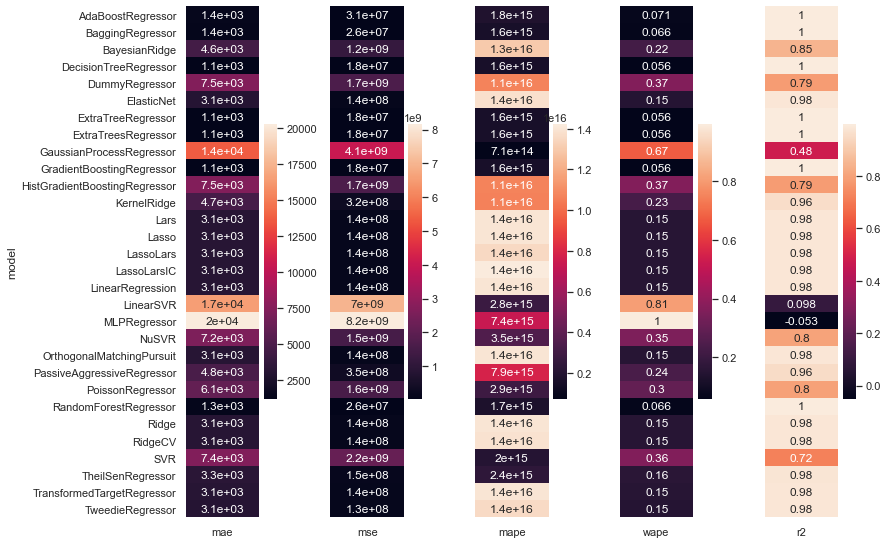

In [11]:
models_scr_heatmap(models_scrs[scrs])

### Performance de cada modelo por tipo de produto

In [12]:
prod_types = ['temporary', 'permanent', 'pasture']
prodtype_models_scrs = []
for scr in sel_scrs:
    prodtype_scr = pd.concat([models_prod_scrs[models_prod_scrs['product_type']==prodtype].set_index('model')[scr] for prodtype in prod_types], 1)
    prodtype_scr.columns = prod_types; prodtype_scr.index.name = scr
    prodtype_models_scrs.append(prodtype_scr)


In [13]:
i=-1

wape


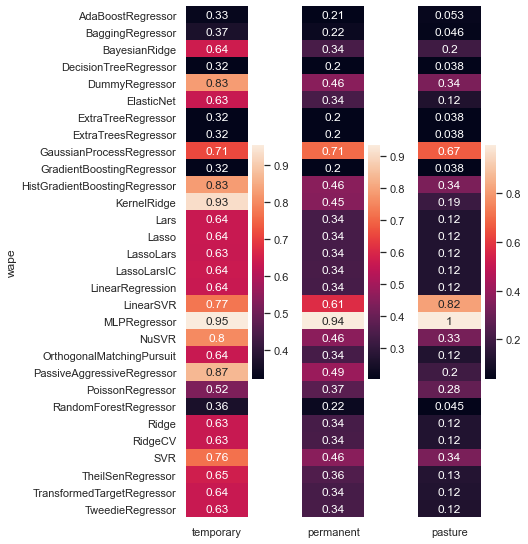

In [21]:
try:
    print(sel_scrs[i+1])
    if i not in range(12): i=-1
except: i=-1
if i==11: i=0
else: i+=1;
models_scr_heatmap(prodtype_models_scrs[i], width=9)

In [22]:
models_prod_scrs[models_prod_scrs['model']=='GradientBoostingRegressor']

,product_type,e,estd,max_error,mae,mse,medae,mape,wape,r2,evs,model
27,temporary,7.332128e+05,2410.053252,36000.194063,571.483054,6.130422e+06,29.757000,2.697526e+15,0.324130,0.877624,0.878232,GradientBoostingRegressor
28,permanent,2.088835e+05,1634.054899,27462.000000,336.908859,2.779336e+06,33.294075,4.094445e+12,0.204108,0.861915,0.863565,GradientBoostingRegressor
29,pasture,1.575864e+06,8801.045295,75257.861330,5471.749443,1.071295e+08,1772.546642,6.167664e-02,0.038092,0.997399,0.997902,GradientBoostingRegressor


### Performance média final para cada modelo (média da performance para os 3 tipos de produto)

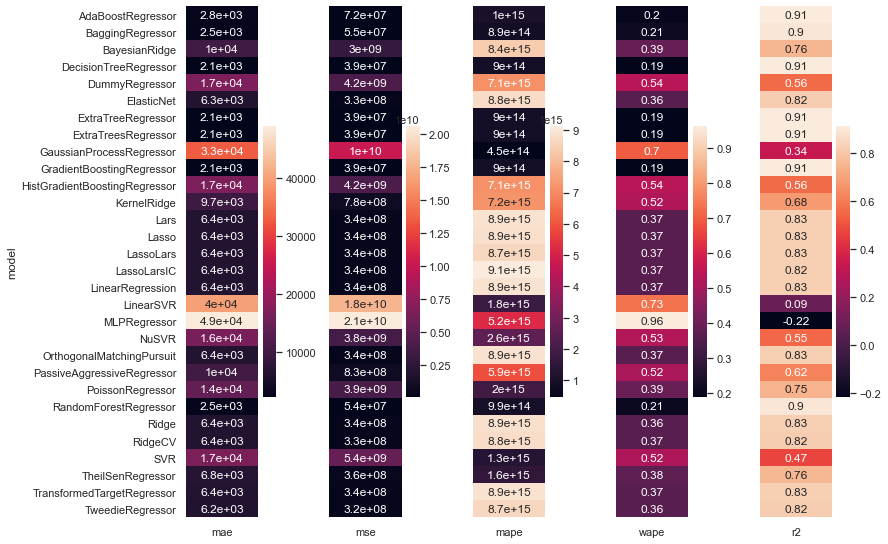

In [23]:
models_prodtype_eval_avgs = models_prod_scrs.groupby(['model', 'product_type']).sum().groupby(['model']).mean()
models_scr_heatmap(models_prodtype_eval_avgs[scrs])

### Including specialized models predictions

In [69]:
Yhat_ext = pd.read_csv('evaluation/specialized_models_predictions.csv', index_col=0)

In [ ]:
specialized_models_names = ['Yhat_AutoReg', 'Yhat_arima', 'Yhat_sarimax', 'Yhat_var', 'Yhat_autoarima']
target_years = ['01/01/2016', '01/01/2017']
ts_specialed_models_scrs = []
specialized_models_predictions = []
for model_name in specialized_models_names:
    model_predictions = []
    for key in keys:
        model_key_yhat = Yhat_ext.set_index('key').loc[key].set_index('year').sort_index()[model_name]
        serie = series[key]
        y_test = serie[serie['year'].isin(target_years)].sort_values('year')[[target, 'year']].copy()
        yhat_i = model_key_yhat.loc[y_test['year']]
        yhat_i.index = y_test.index
        info = [key, model_name]
        key_model_scrs = info + score_predictions_custom(y_test[target], yhat_i.fillna(0), scorers=scorers)
        ts_specialed_models_scrs.append(key_model_scrs)
        model_predictions.append(yhat_i)
    model_predictions = pd.concat(model_predictions, 0)
    model_predictions.name = model_name
    specialized_models_predictions.append(model_predictions)

ts_specialized_scrs = pd.DataFrame(ts_specialed_models_scrs, columns=['city-product', 'model'] + scorers_names)
specialized_prediction = pd.concat(specialized_models_predictions, 1)

### Scoring models for each serie and sorting models by metric criterias

In [150]:
ts_models_scrs_ext = pd.concat([ts_models_scrs, ts_specialized_scrs])
models_prediction_ext = pd.concat([models_prediction, specialized_prediction.loc[models_prediction.index]], 1)

In [155]:
criteria_predictions = []
cnt, n = 0, len(sel_scrs)
for i, criteria in enumerate(sel_scrs[:]):
    co(wait=True); print(f'Predictions by criteria: {i+1} - {n}')
    y_hat_by_scr = predict_by_criteria(criteria, ts_models_scrs_ext, models_prediction_ext)
    criteria_predictions.append(y_hat_by_scr)
pred_by_score = pd.concat(criteria_predictions, 1)

In [156]:
#### Calculating scores for each criteria prediction
a, b = [], []
for col in pred_by_score:
    a1, b1 = score_model_predictions(pred_by_score[col].fillna(0), model_name=col)
    b1['model'] = col
    a.append(a1); b.append(b1)
    
criteria_scrs, criteria_prod_scrs = [pd.concat(scrs) for scrs in [a, b]]

In [157]:
decision_metric = 'mae'
[display(criteria_prod_scrs[criteria_prod_scrs['product_type']==prodtype].sort_values(decision_metric)) for prodtype in prodtypes]

,product_type,mae,mse,mape,wape,r2,model
1,permanent,247.115762,2.525091e+06,6.788683e+13,0.149709,0.874546,e_selected_model
1,permanent,247.115762,2.525091e+06,6.788683e+13,0.149709,0.874546,mae_selected_model
1,permanent,247.115762,2.525091e+06,6.788683e+13,0.149709,0.874546,medae_selected_model
1,permanent,247.630122,2.525123e+06,2.384358e+15,0.150020,0.874545,wape_selected_model
1,permanent,248.807725,2.518354e+06,6.829947e+13,0.150734,0.874881,mse_selected_model
1,permanent,249.874590,2.557771e+06,1.756590e-01,0.151380,0.872923,mape_selected_model
1,permanent,250.180163,2.519659e+06,1.699245e+14,0.151565,0.874816,max_error_selected_model
1,permanent,312.407455,2.769534e+06,6.829947e+13,0.189264,0.862402,r2_selected_model
1,permanent,367.365643,2.718164e+06,4.300915e+14,0.222559,0.864954,estd_selected_model
1,permanent,654.050091,5.971659e+06,3.871451e+14,0.396239,0.703311,evs_selected_model


,product_type,mae,mse,mape,wape,r2,model
0,temporary,290.574525,2.218299e+06,4.962596e+14,0.164806,0.955718,e_selected_model
0,temporary,290.574525,2.218299e+06,4.962596e+14,0.164806,0.955718,mae_selected_model
0,temporary,290.574525,2.218299e+06,4.962596e+14,0.164806,0.955718,medae_selected_model
0,temporary,291.901748,2.218969e+06,6.473542e+15,0.165559,0.955705,wape_selected_model
0,temporary,296.269355,2.033963e+06,5.911175e+14,0.168036,0.959398,mse_selected_model
0,temporary,298.965675,2.514665e+06,2.919688e+14,0.169565,0.949802,mape_selected_model
0,temporary,307.128070,2.115015e+06,1.079550e+15,0.174195,0.957780,max_error_selected_model
0,temporary,349.264672,2.237952e+06,8.976134e+14,0.198093,0.955326,r2_selected_model
0,temporary,714.504485,9.678558e+06,2.407208e+15,0.405248,0.806797,estd_selected_model
0,temporary,854.556887,1.124814e+07,2.926493e+15,0.484681,0.775464,evs_selected_model


,product_type,mae,mse,mape,wape,r2,model
2,pasture,1904.927502,1.363438e+07,0.023406,0.013261,0.999669,e_selected_model
2,pasture,1904.927502,1.363438e+07,0.023406,0.013261,0.999669,mae_selected_model
2,pasture,1904.927502,1.363438e+07,0.023406,0.013261,0.999669,medae_selected_model
2,pasture,1904.927502,1.363438e+07,0.023406,0.013261,0.999669,wape_selected_model
2,pasture,1906.025516,1.381016e+07,0.023274,0.013269,0.999665,mape_selected_model
2,pasture,1916.075296,1.346936e+07,0.023579,0.013339,0.999673,mse_selected_model
2,pasture,1916.075296,1.346936e+07,0.023579,0.013339,0.999673,r2_selected_model
2,pasture,1925.142751,1.350397e+07,0.023832,0.013402,0.999672,max_error_selected_model
2,pasture,22528.653355,3.958630e+09,0.176127,0.156834,0.903883,estd_selected_model
2,pasture,30807.894842,7.471496e+09,0.219676,0.214471,0.818589,evs_selected_model


[None, None, None]

In [158]:
criteria_prod_scrs[criteria_prod_scrs['model']=='e_selected_model']

,product_type,mae,mse,mape,wape,r2,model
0,temporary,290.574525,2.218299e+06,4.962596e+14,0.164806,0.955718,e_selected_model
1,permanent,247.115762,2.525091e+06,6.788683e+13,0.149709,0.874546,e_selected_model
2,pasture,1904.927502,1.363438e+07,2.340605e-02,0.013261,0.999669,e_selected_model


In [28]:
criteria_prod_scrs[criteria_prod_scrs['model']=='e_selected_model']

,product_type,mae,mse,mape,wape,r2,model
0,temporary,321.104053,2.459749e+06,4.444070e+14,0.182122,0.950898,e_selected_model
1,permanent,268.197758,2.566188e+06,2.820213e+14,0.162481,0.872505,e_selected_model
2,pasture,3212.755844,4.522673e+07,3.023248e-02,0.022366,0.998902,e_selected_model


### Manually structuring custom model prediction

##### The model is going to be composed of 'e_selected' models for 'temporary' and 'pasture' product type series and gbr models for 'permanent' product type series

In [190]:
sel_model = 'GradientBoostingRegressor'
sel_criteria = 'e_selected_model'
Y_hat_final = pred_by_score[sel_criteria].fillna(0).loc[Y_e.index].copy()

In [191]:
len(pred_by_score)

2191

In [192]:
final_scrs, final_prod_scrs = score_model_predictions(Y_hat_final, model_name='final custom model')

#### Manual Selection
prodtypes_test_index = pd.concat([prodtype_indexes[prodtype].to_series() for prodtype in ['temporary', 'pasture']]).values
gbr_pred_index = set(Y_e.index).difference(prodtypes_test_index)
r2_pred = pred_by_score[sel_criteria].loc[prodtypes_test_index]
gbr_pred = models_prediction[sel_model].loc[gbr_pred_index]
Y_hat_final = pd.concat([gbr_pred, r2_pred]).loc[Y_e.index]
Y_hat_final.name = 'destinated_area'
final_scrs, final_prod_scrs = score_model_predictions(Y_hat_final, model_name='final custom model')

In [193]:
final_prod_scrs

,product_type,mae,mse,mape,wape,r2
0,temporary,290.574525,2.218299e+06,4.962596e+14,0.164806,0.955718
1,permanent,247.115762,2.525091e+06,6.788683e+13,0.149709,0.874546
2,pasture,1904.927502,1.363438e+07,2.340605e-02,0.013261,0.999669


In [194]:
final_wape_scr = final_prod_scrs['wape'].mean(); final_wape_scr

0.10925865310918355

### Extracting submission table

In [285]:
data_evaluation_raw = data[data['year'].isin(['01/01/2016', '01/01/2017'])].copy()
data_evaluation = data_evaluation_raw.dropna(subset=['area']).reset_index().rename(columns={'index': 'Index'})
submission = pd.merge(data_evaluation, Y_hat_final.to_frame(), on='Index', how='left').drop(['area'], 1).rename(columns={Y_hat_final.name: 'destinated_area'})
submission.loc[submission[submission['Index'].isin(excluded_test_index)].index, 'destinated_area'] = 0
submission['year'] = submission['year'].map(lambda year: year[-4:]+'-01-01')

yhat_sub = submission.set_index('Index')['destinated_area'].copy()
y_test = data.loc[yhat_sub.index]['area'].copy()
sub_scrs = score_by_product(y_test, yhat_sub, model_name, key='product_type', scorers=scorers, scorers_names=scorers_names)

submission = submission.drop('Index', 1)
# submission.to_csv('submission/partial_submission.csv', index=False)
# submission.to_excel('submission/partial_submission.xlsm', index=False)

In [306]:
submission = pd.read_csv('submission/partial_submission.csv')

In [310]:
len(data_evaluation_raw), len(data_evaluation), len(data_e), len(Y_hat_final),  len(submission)

(3424, 2226, 2191, 2191, 2226)

In [313]:
sub_scrs['wape'].mean()

0.10925865310918355

In [312]:
submission.head()

,year,city_code,product_type,product,destinated_area
0,2016-01-01,960b4f2c94a2fb2c,temporary,Others,190.268052
1,2016-01-01,746cc42bfb8f6b62,temporary,Others,0.000000
2,2016-01-01,6cce2bf873870afc,temporary,Others,0.000000
3,2016-01-01,4de42e351006a2ae,temporary,Others,0.000000
4,2016-01-01,5b6072f8f6d37acc,temporary,Others,20.860747


---
## Rebuilding model for production

In [244]:
def load_ts_model(key, path='models/regressors/'):    
    return pickle.load(open(path+key+'.sav', 'rb'))

### Constructing series_key-model map manually

In [183]:
import json
key_model_map = top_models_per_ts(ts_models_scrs_ext, criteria='e')
# Saving key-model map
#json.dump(key_model_map, open('models/model_key_map.json', 'w'))

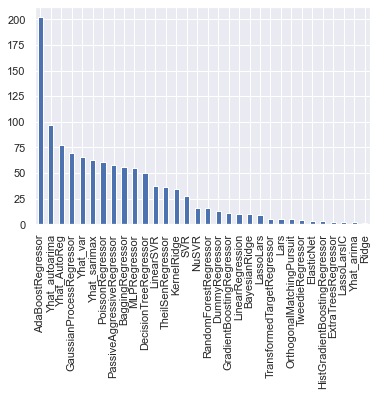

In [189]:
pd.Series(key_model_map).value_counts().plot.bar()

#### Custom key-model mapping
sel_models = top_models_per_ts(ts_models_scrs, criteria='e')
key_model_map = {}
for key in series.keys():
    if key_prodtype_map[key]=='permanent':
        key_model_map[key] = sel_model
    else:
        key_model_map[key] = sel_models[key]

In [251]:
#### Loading key-model map
key_model_map = json.load(open('models/model_key_map.json', 'r'))

### Defining custom model class

In [252]:
class CustomModel:
    
    def __init__(self, key_regressor_map):
        self.key_map = key_regressor_map
        self.n_keys = len(self.key_map)
        self.ts_models = {}
        for i, key in enumerate(self.key_map.keys()):
            self.ts_models[key] = load_ts_model(key=self.key_map[key]+'_'+key)
            co(wait=True); print(f'Loaded ts models: {i+1}/{self.n_keys}')
        co(wait=True); print(f'Done! Loaded {self.n_keys} ts models.')

    def predict(self, x):
        yhat = []
        for index in x.index:
            key = key_test_index_map[index]
#             row = x.loc[index]
#             key = row['city_code']+'-'+row['product']
#             if row['product']=='Others': key+='-'+row['product_type']
            xe = label_encode(x.loc[[index], ['year']].copy(), base=data)
            yhat.append(self.ts_models[key].predict(xe)[0])
        return pd.Series(yhat, index=x.index)

In [253]:
custom_model = CustomModel(key_model_map)

Done! Loaded 1107 ts models.


In [264]:
xe, ye = get_xy(data_e)

In [265]:
yhat = custom_model.predict(xe)

In [266]:
custom_scrs, custom_prod_scrs = score_model_predictions(yhat, y_e=ye, model_name='CustomModel')

In [268]:
custom_scrs

,mae,mse,mape,wape,r2
CustomModel,20372.334914,8.163259e+09,1.159646e+15,0.999556,-0.053567


In [267]:
custom_prod_scrs

,product_type,mae,mse,mape,wape,r2
0,temporary,1754.798239,5.314900e+07,1.686880e+15,0.995274,-0.060961
1,permanent,1640.814482,2.281455e+07,6.072877e+14,0.994045,-0.133490
2,pasture,143635.675961,6.181724e+10,9.990621e-01,0.999926,-0.500952


### Performance de cada modelo por tipo de produto

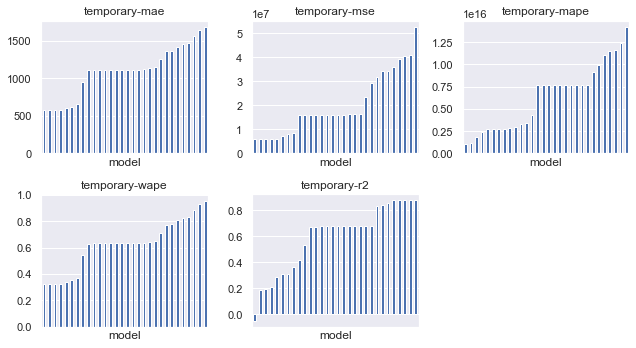

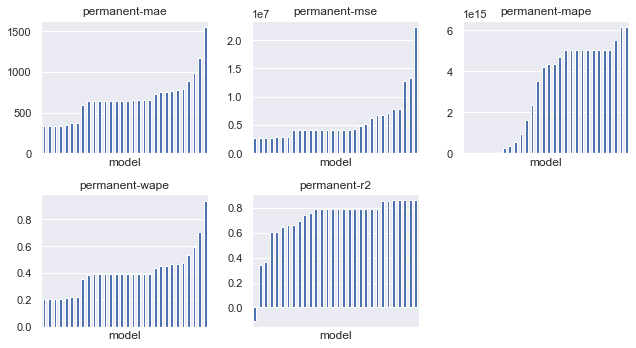

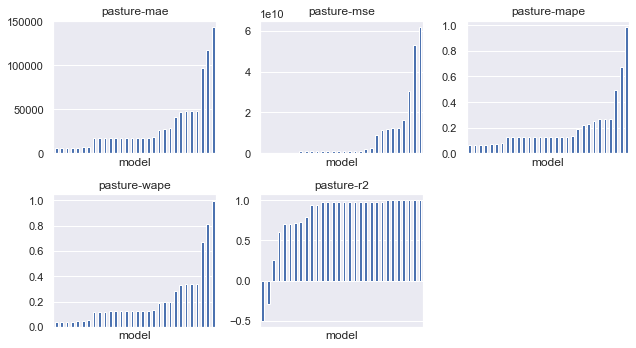

In [187]:
for product in models_prod_scrs['product_type'].unique():
    fig = plt.figure(figsize=(9,5), tight_layout=True)
    axes = [fig.add_subplot(2, 3, i) for i in [1,2,3,4,5]]
    prod_df = models_prod_scrs[models_prod_scrs['product_type']==product].set_index('model')
    for col, ax in zip(scrs, axes):
        prod_df[col].sort_values().plot.bar(ax=ax)
        ax.set(title=product+'-'+col, xticks=[])
    plt.show()